# TP : Représentation et Visualisation de mots avec Word2Vec et t-SNE

Objectifs 
1. Extraire et tokeniser le texte d'un document PDF.
2. Représenter les mots de façon vectorielle (embeddings).
3. Visualiser ces représentations en 2D avec **t-SNE**.
4. Entraîner notre propre modèle Word2Vec et comparer avec un modèle pré-entraîné.
5. Ajouter une classification non supervisée pour faire apparaître des classes de mots.

Packages Nécessaires : 
```
pip install gensim
pip install matplotlib
pip install scikit-learn 
pip install nltk 
pip install PyMuPDF
```

In [ ]:
import fitz
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

## Partie 1 : Extraction et Visualisation avec un modèle pré-entraîné

Dans cette première partie :
- Charger un fichier PDF
- Tokeniser le texte en mots
- Utiliser le modèle **Word2Vec Google News** pré-entraîné
- Réduire la dimension avec t-SNE
- Visualiser les mots en 2D


In [ ]:
nltk.download("punkt")

In [ ]:
# 1. Extraction du texte PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text")
    return text

In [ ]:
# 2. Tokenisation simple
def tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    return tokens

In [ ]:
# 3. Charger un modèle pré-entraîné (Google News)
model = api.load("word2vec-google-news-300")

In [ ]:
# 4. Générér les Embeddings
def generates_embeddings(tokens):
    unique_tokens = list(set(tokens))
    embeddings = []
    words_in_model = []
    
    for word in unique_tokens:
        if word in model:
            embeddings.append(model[word])
            words_in_model.append(word)
    
    return embeddings, words_in_model

In [ ]:
# 4. Pipeline
pdf_path = "./cours_LLM.pdf"
text = extract_text_from_pdf(pdf_path)
tokens = tokenize(text)
embeddings, words_in_model = generates_embeddings(tokens)

In [ ]:
# 5. Réduction de dimension
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

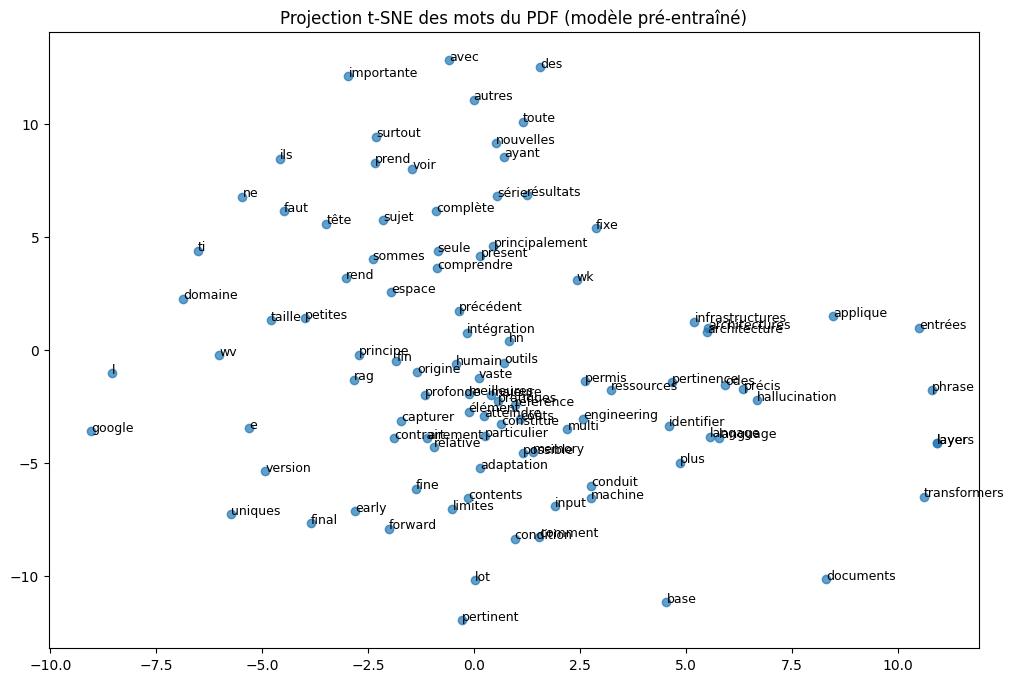

In [46]:
# 6. Visualisation
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:100, 0], embeddings_2d[:100, 1], alpha=0.7)
for i, word in enumerate(words_in_model[:100]):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
plt.title("Projection t-SNE des mots du PDF (modèle pré-entraîné)")
plt.show()

## Partie 2 : Entraîner un modèle Word2Vec (CBOW) sur le PDF

Dans cette partie :
- Améliorer la tokenisation (enlever les stop words, ...) 
- Entraîner un modèle **Word2Vec CBOW** directement sur le contenu du PDF
- Visualiser les résultats

In [ ]:
nltk.download("stopwords")

In [ ]:
# 1. Tokenisation + nettoyage
def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words("french"))
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

In [ ]:
# 2. Entraînement Word2Vec (CBOW)
def train_word2vec(tokens):
    model = Word2Vec(
        sentences=[tokens],
        vector_size=50,
        window=5,
        min_count=2,
        sg=0,   # CBOW
        workers=4,
        epochs=100
    )
    return model

In [ ]:
# 3. Extraire embeddings
def get_embeddings(model, top_n=100):
    words = model.wv.index_to_key[:top_n]
    vectors = np.array([model.wv[w] for w in words])
    return words, vectors

In [ ]:
# 4. Réduction et visualisation
def reduce_with_tsne(vectors, words):
    perplexity = min(30, len(words)-1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    return tsne.fit_transform(vectors)

In [ ]:
def plot_embeddings(reduced, words, title="t-SNE (Word2Vec CBOW)"):
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
    for i, word in enumerate(words):
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9)
    plt.title(title)
    plt.show()

In [ ]:
# Pipeline Finale
text = extract_text_from_pdf(pdf_path) 
tokens = tokenize_text(text)
model = train_word2vec(tokens)
words, vectors = get_embeddings(model, top_n=100)
reduced = reduce_with_tsne(vectors, words)
plot_embeddings(reduced, words, "Projection t-SNE (Word2Vec CBOW, PDF)")

## Partie 3 : Classification non supervisée des mots

Pour mieux comprendre la structure des mots :
- Entraînement d'un clustering **KMeans** sur les vecteurs Word2Vec


In [ ]:
# 1. Clustering
def cluster_embeddings(vectors, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    return kmeans.fit_predict(vectors)

In [ ]:
# 2. Visualisation avec couleurs par cluster
def plot_embeddings_clusters(reduced, words, labels, title="t-SNE avec clustering"):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
    for i, word in enumerate(words):
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9)
    plt.title(title)
    plt.colorbar(scatter, label="Cluster")
    plt.show()

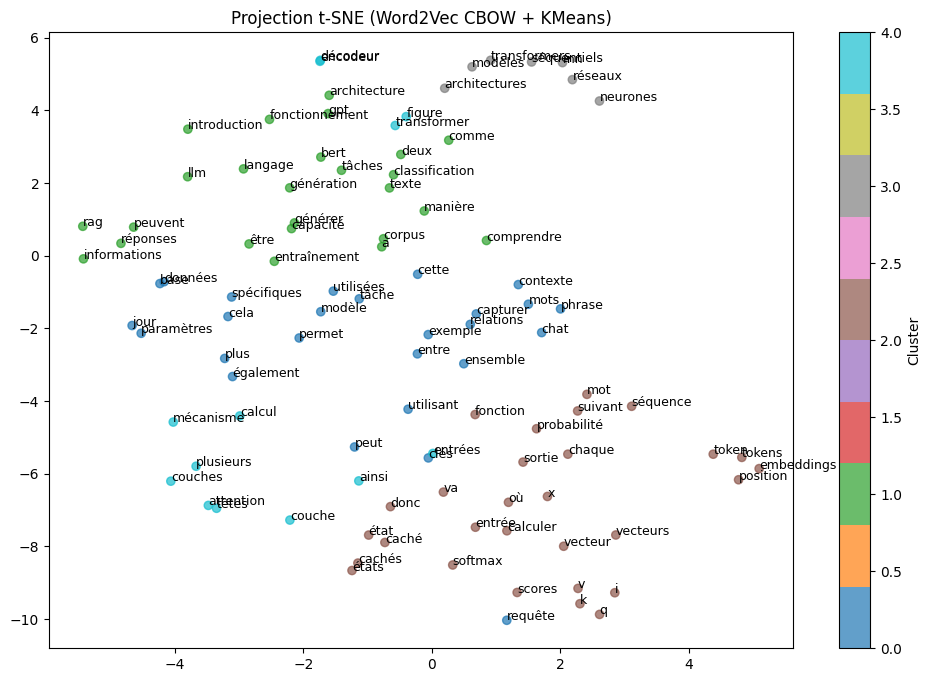

In [42]:
# Pipeline Finale
labels = cluster_embeddings(vectors, n_clusters=5)
plot_embeddings_clusters(reduced, words, labels, "Projection t-SNE (Word2Vec CBOW + KMeans)")